In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=459fba933f1d3badf685562861e72443bb7a0ebb9e28349d929d55847c3d3afe
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master('local[*]')\
        .appName('Regression with Spark')\
        .getOrCreate()

spark        

**Montando o drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive') #dar acesso ao notebook aos arquivos do drive

Mounted at /content/drive


In [4]:
df = spark.read.json ('/CAMINHO_DRIVE/imoveis.json')
df

DataFrame[ident: struct<customerID:string,source:string>, listing: struct<address:struct<city:string,location:struct<lat:double,lon:double>,neighborhood:string,zone:string>,features:struct<bathrooms:bigint,bedrooms:bigint,floors:bigint,parkingSpaces:bigint,suites:bigint,totalAreas:string,unitFloor:bigint,unitsOnTheFloor:bigint,usableAreas:string>,prices:struct<price:string,tax:struct<condo:string,iptu:string>>,types:struct<unit:string,usage:string>>]

In [5]:
df.show(truncate = False)

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{775564-BOJSMVON, Website}|{{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}, {0, 0, 0, 1, 0, 62, 0, 0, 62}, {45000, {150, 0}}, {Outros, Residencial}}                       |
|{660895-AUENKNYY, Website}|{{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}, {1, 2, 0, 1, 0, 0, 0, 0, 44}, {45000, {120, 0}}, {Apartamento, Residencial}}                |
|{751522-JESYFEQL, Website}|{{Rio de Janeiro,

In [6]:
df.count()

73615

**Seleção das *Features***

In [7]:
df.printSchema()

root
 |-- ident: struct (nullable = true)
 |    |-- customerID: string (nullable = true)
 |    |-- source: string (nullable = true)
 |-- listing: struct (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- location: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- neighborhood: string (nullable = true)
 |    |    |-- zone: string (nullable = true)
 |    |-- features: struct (nullable = true)
 |    |    |-- bathrooms: long (nullable = true)
 |    |    |-- bedrooms: long (nullable = true)
 |    |    |-- floors: long (nullable = true)
 |    |    |-- parkingSpaces: long (nullable = true)
 |    |    |-- suites: long (nullable = true)
 |    |    |-- totalAreas: string (nullable = true)
 |    |    |-- unitFloor: long (nullable = true)
 |    |    |-- unitsOnTheFloor: long (nullable = true)
 |    |    |-- usableAreas: string (nullable =

In [8]:
df.select('ident.customerID', 'listing.*')\
     .show(truncate = False)

+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|customerID     |address                                                                         |features                       |prices               |types                     |
+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|775564-BOJSMVON|{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}                 |{0, 0, 0, 1, 0, 62, 0, 0, 62}  |{45000, {150, 0}}    |{Outros, Residencial}     |
|660895-AUENKNYY|{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}              |{1, 2, 0, 1, 0, 0, 0, 0, 44}   |{45000, {120, 0}}    |{Apartamento, Residencial}|
|751522-JESYFEQL|{Rio de Janeiro, {-22.986927, -43.646786}, Pedra de Guaratiba, Zona Oeste}      |{0

In [9]:
df.select('ident.customerID','listing.address.*', 'listing.features.*', 'listing.prices.*', 'listing.types.*')\
     .show(truncate = False)

+---------------+--------------+------------------------+------------------------+------------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+-----+------------+-----------+-----------+
|customerID     |city          |location                |neighborhood            |zone        |bathrooms|bedrooms|floors|parkingSpaces|suites|totalAreas|unitFloor|unitsOnTheFloor|usableAreas|price|tax         |unit       |usage      |
+---------------+--------------+------------------------+------------------------+------------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+-----+------------+-----------+-----------+
|775564-BOJSMVON|Rio de Janeiro|{-22.909429, -43.413557}|Taquara                 |Zona Oeste  |0        |0       |0     |1            |0     |62        |0        |0              |62         |45000|{150, 0}    |Outros     |Residencial|
|660895-AUENKNYY|Rio de Janeiro|{-22.869698, -43.509141}|San

In [10]:
df.select('ident.customerID','listing.address.*', 'listing.features.*', 'listing.prices.price', 'listing.prices.tax.*')\
     .drop('city', 'totalAreas', 'location')\
     .show(truncate = False)

+---------------+------------------------+------------+---------+--------+------+-------------+------+---------+---------------+-----------+-----+-----+----+
|customerID     |neighborhood            |zone        |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|price|condo|iptu|
+---------------+------------------------+------------+---------+--------+------+-------------+------+---------+---------------+-----------+-----+-----+----+
|775564-BOJSMVON|Taquara                 |Zona Oeste  |0        |0       |0     |1            |0     |0        |0              |62         |45000|150  |0   |
|660895-AUENKNYY|Santíssimo              |Zona Oeste  |1        |2       |0     |1            |0     |0        |0              |44         |45000|120  |0   |
|751522-JESYFEQL|Pedra de Guaratiba      |Zona Oeste  |0        |0       |0     |0            |0     |0        |0              |132        |50000|100  |0   |
|714052-GAAEWYKS|Cascadura               |Zona Norte

In [11]:
#criar um dataset com as features selecionadas
dataset = df.select('ident.customerID', 'listing.address.*', 'listing.types.*', 'listing.features.*', 'listing.prices.price', 'listing.prices.tax.*')\
               .drop('city', 'totalAreas', 'location')

In [12]:
dataset.toPandas()

,customerID,neighborhood,zone,unit,usage,bathrooms,bedrooms,floors,parkingSpaces,suites,unitFloor,unitsOnTheFloor,usableAreas,price,condo,iptu
0,775564-BOJSMVON,Taquara,Zona Oeste,Outros,Residencial,0,0,0,1,0,0,0,62,45000,150,0
1,660895-AUENKNYY,Santíssimo,Zona Oeste,Apartamento,Residencial,1,2,0,1,0,0,0,44,45000,120,0
2,751522-JESYFEQL,Pedra de Guaratiba,Zona Oeste,Outros,Residencial,0,0,0,0,0,0,0,132,50000,100,0
3,714052-GAAEWYKS,Cascadura,Zona Norte,Outros,Comercial,1,0,0,0,0,3,0,32,45000,468,346
4,568886-ZIBFOMCC,Recreio dos Bandeirantes,Zona Oeste,Apartamento,Residencial,2,3,3,1,1,2,4,60,50000,400,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73610,134148-MJIBCMDQ,Barra da Tijuca,Zona Oeste,Casa,Residencial,10,5,0,4,1,0,0,1024,10000000,2350,2900
73611,541465-QBQVXXXZ,Barra da Tijuca,Zona Oeste,Casa,Residencial,7,5,0,6,5,0,0,750,10000000,3000,15000
73612,800542-BZREFTQS,Copacabana,Zona Sul,Apartamento,Residencial,5,4,0,3,4,0,0,328,10000000,None,None
73613,939419-ECGUNTIH,Barra da Tijuca,Zona Oeste,Casa,Residencial,10,5,0,4,5,3,0,1024,10000000,2400,35000


In [13]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)



**Tratamento dos Dados**

In [14]:
from pyspark.sql.types import IntegerType, DoubleType

In [15]:
#modificações das colunas de string para integer e double(numeros quebrado) e visualizar o schema
dataset\
    .withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))\
    .withColumn('price', dataset['price'].cast(DoubleType()))\
    .withColumn('condo', dataset['condo'].cast(DoubleType()))\
    .withColumn('iptu', dataset['iptu'].cast(DoubleType()))\
    .printSchema()

root
 |-- customerID: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- condo: double (nullable = true)
 |-- iptu: double (nullable = true)



In [16]:
dataset = dataset\
    .withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))\
    .withColumn('price', dataset['price'].cast(DoubleType()))\
    .withColumn('condo', dataset['condo'].cast(DoubleType()))\
    .withColumn('iptu', dataset['iptu'].cast(DoubleType()))


In [17]:
dataset.show()

+---------------+--------------------+------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+-------+-----+------+
|     customerID|        neighborhood|        zone|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|  price|condo|  iptu|
+---------------+--------------------+------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+-------+-----+------+
|775564-BOJSMVON|             Taquara|  Zona Oeste|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|45000.0|150.0|   0.0|
|660895-AUENKNYY|          Santíssimo|  Zona Oeste|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|45000.0|120.0|   0.0|
|751522-JESYFEQL|  Pedra de Guaratiba|  Zona Oeste|     Outros|Residencial|        0|     

In [18]:
#analisando a coluna usage
dataset.select('usage')\
       .groupBy('usage')\
       .count()\
       .show()

+-----------+-----+
|      usage|count|
+-----------+-----+
|  Comercial| 4019|
|Residencial|69596|
+-----------+-----+



In [19]:
#como queremos analisar apenas imoveis residencias para a regressão de preço, iremos descartar imoveis comerciais
dataset = dataset.select('*')\
          .where('usage=="Residencial"')

In [20]:
#analisando a coluna unit
dataset.select('unit')\
       .groupBy('unit')\
       .count()\
       .show()

+-----------+-----+
|       unit|count|
+-----------+-----+
|     Outros| 1190|
|Apartamento|59106|
|       Casa| 9300|
+-----------+-----+



In [21]:
#analisando a coluna zone
dataset.select('zone')\
       .groupBy('zone')\
       .count()\
       .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



**Tratamento dos dados faltantes**

In [22]:
from pyspark.sql import functions as f

In [23]:
dataset.show()

+---------------+--------------------+------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+-------+-----+-----+
|     customerID|        neighborhood|        zone|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|  price|condo| iptu|
+---------------+--------------------+------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+-------+-----+-----+
|775564-BOJSMVON|             Taquara|  Zona Oeste|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|45000.0|150.0|  0.0|
|660895-AUENKNYY|          Santíssimo|  Zona Oeste|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|45000.0|120.0|  0.0|
|751522-JESYFEQL|  Pedra de Guaratiba|  Zona Oeste|     Outros|Residencial|        0|       0| 

In [24]:
#contagem de registros nulos ou faltantes
dataset\
      .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
      .show()

+----------+------------+----+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+-----+-----+----+
|customerID|neighborhood|zone|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|price|condo|iptu|
+----------+------------+----+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+-----+-----+----+
|         0|           0|   0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|    0| 6061|8726|
+----------+------------+----+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+-----+-----+----+



In [25]:
#trocando valores nulos por zero
dataset\
    .select('*')\
    .na\
    .fill(0)\
    .show()

+---------------+--------------------+------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+-------+-----+-----+
|     customerID|        neighborhood|        zone|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|  price|condo| iptu|
+---------------+--------------------+------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+-------+-----+-----+
|775564-BOJSMVON|             Taquara|  Zona Oeste|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|45000.0|150.0|  0.0|
|660895-AUENKNYY|          Santíssimo|  Zona Oeste|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|45000.0|120.0|  0.0|
|751522-JESYFEQL|  Pedra de Guaratiba|  Zona Oeste|     Outros|Residencial|        0|       0| 

In [26]:
#aplicando alteração no dataset e verificando novamente se há valores nulos 
dataset = dataset\
    .select('*')\
    .na\
    .fill(0)

dataset\
      .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
      .show()    

+----------+------------+----+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+-----+-----+----+
|customerID|neighborhood|zone|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|price|condo|iptu|
+----------+------------+----+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+-----+-----+----+
|         0|           0|   0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|    0|    0|   0|
+----------+------------+----+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+-----+-----+----+



*insight: visto que a coluna zone nao estava com dados faltantes ou nulos, então necessário uma nova analise perante a mesma*

In [27]:
dataset.select('zone')\
       .groupBy('zone')\
       .count()\
       .show()     

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



In [28]:
#há 157 dados vazios, potencialmente é uma string vazia, no caso, queremos então apenas os dados que não contem a string vazia dentro de todo o conjunto
dataset = dataset\
              .where(f.col('zone') != '')

**REGRESSÃO LINEAR - LINEAR REGRESSION**



> **Preparação dos dados - *Variáveis Dummy***
Como há variáveis categóricas, é melhor usar variaveis dummy, como exemplo, na coluna 'unit' temos: apartamento, casa e outros. A melhor maneira de se trabalhar é ter uma coluna para apartamento, outro casa e outro pra outros, e assim, quando há, ou não, ter esse imovel, colocar 0 e 1.

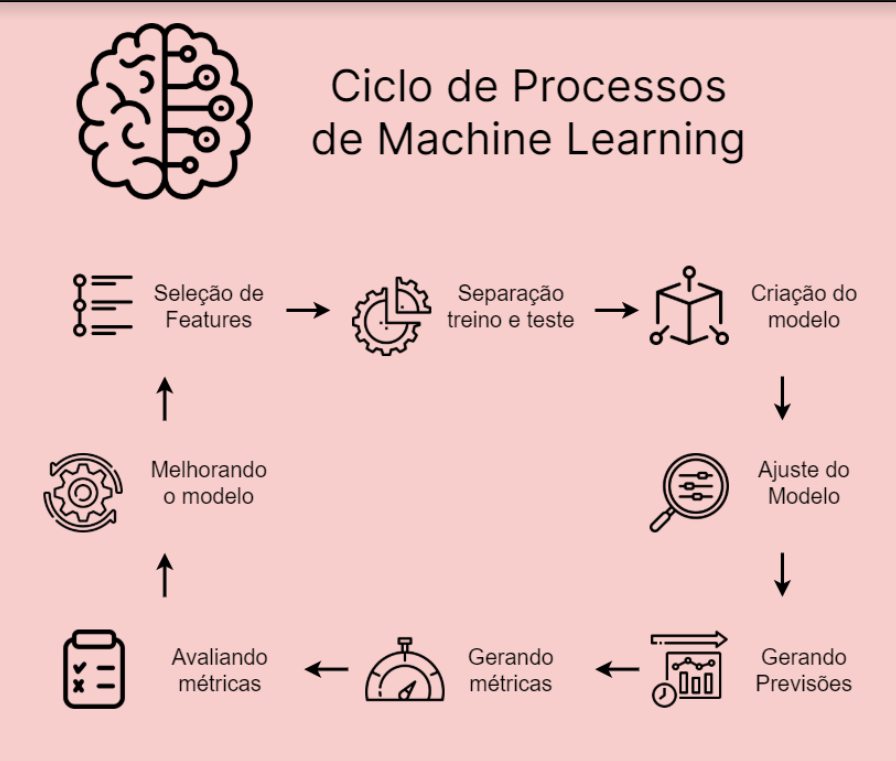






In [29]:
dataset\
    .groupBy('customerID')\
    .pivot('unit')\
    .agg(f.lit(1))\
    .na\
    .fill(0)\
    .show()

+---------------+-----------+----+------+
|     customerID|Apartamento|Casa|Outros|
+---------------+-----------+----+------+
|062130-QKYMWGMV|          1|   0|     0|
|630945-AEEUPRXI|          0|   1|     0|
|994985-OZQNHQKH|          1|   0|     0|
|494674-JWXRZIBM|          1|   0|     0|
|458844-UJCRFSRI|          1|   0|     0|
|155284-BRCDAOIQ|          1|   0|     0|
|396742-DUXBHLRU|          1|   0|     0|
|916072-ZJXARAXO|          1|   0|     0|
|943843-BVTWWHRQ|          1|   0|     0|
|193126-MTNIIFQN|          1|   0|     0|
|319762-UXTTQYFS|          1|   0|     0|
|931151-GZCTKADB|          1|   0|     0|
|103840-OFKPFEZJ|          0|   1|     0|
|176885-NNKZRQGM|          0|   1|     0|
|926638-PBYRAZYR|          1|   0|     0|
|744421-IZJWISWB|          1|   0|     0|
|530012-TYGLQMER|          1|   0|     0|
|209407-GTEUOVKR|          1|   0|     0|
|289667-ZPHGFHJH|          1|   0|     0|
|859388-EYTPMKER|          1|   0|     0|
+---------------+-----------+----+

In [30]:
unit = dataset\
        .groupBy('customerID')\
        .pivot('unit')\
        .agg(f.lit(1))\
        .na\
        .fill(0)
       

In [31]:
zone = dataset\
    .groupBy('customerID')\
    .pivot('zone')\
    .agg(f.lit(1))\
    .na\
    .fill(0)


In [32]:
#junção dos dataset
dataset = dataset\
              .join(unit, 'customerID', how = 'inner')\
              .join(zone, 'customerID', how = 'inner')

In [33]:
dataset.show()

+---------------+--------------------+------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|        neighborhood|        zone|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|  price|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+--------------------+------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|             Taquara|  Zona Oeste|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

**Vetorização dos dados**

In [34]:
from pyspark.ml.feature import VectorAssembler

In [35]:
#alterando o nome da coluna alvo para um nome usual pelo spark
dataset = dataset.withColumnRenamed('price', 'label')

In [36]:
#vetor com as features para o modelo
x = [
    'bathrooms',
    'bedrooms',
    'floors',
    'parkingSpaces',
    'suites',
    'unitFloor',
    'unitsOnTheFloor',
    'usableAreas',
    'condo',
    'iptu',
    'Apartamento',
    'Casa',
    'Outros',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul'
]


In [37]:
#vetorização
assembler = VectorAssembler(inputCols = x, outputCol = 'features')

In [38]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [39]:
dataset_prep.show(10, truncate=False)


+--------------------------------------------------------------------------+-------+
|features                                                                  |label  |
+--------------------------------------------------------------------------+-------+
|(17,[3,7,8,12,15],[1.0,62.0,150.0,1.0,1.0])                               |45000.0|
|(17,[0,1,3,7,8,10,15],[1.0,2.0,1.0,44.0,120.0,1.0,1.0])                   |45000.0|
|(17,[7,8,12,15],[132.0,100.0,1.0,1.0])                                    |50000.0|
|[2.0,3.0,3.0,1.0,1.0,2.0,4.0,60.0,400.0,120.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0]|50000.0|
|(17,[7,12,15],[200.0,1.0,1.0])                                            |50000.0|
|(17,[0,1,3,7,10,14],[1.0,1.0,1.0,33.0,1.0,1.0])                           |45336.0|
|(17,[7,12,15],[120.0,1.0,1.0])                                            |45000.0|
|(17,[7,12,15],[468.0,1.0,1.0])                                            |45000.0|
|(17,[5,7,12,15],[1.0,180.0,1.0,1.0])                            

**Exploração dos Dados**

In [40]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [41]:
#correlacao entre as variaveis (matriz de correlacao)
correlacao = Correlation.corr(dataset_prep, 'features').collect()

In [42]:
correlacao

[Row(pearson(features)=DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False))]

Temos um *Row*, significa que há mais de uma coluna e mais de uma linha. Também temos a correlação de *pearson* das features, que é uma **DenseMatrix**.Queremos trabalhar apenas com a correlação de *pearson*, então vamos coletar só o objeto da linha 1, na coluna 1, que é a correlação de *pearson*.

In [43]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()[0][0]

In [44]:
correlacao

DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False)

In [45]:
#transformando a matriz em um array (melhor para trabalhar)
correlacao.toArray()

array([[ 1.00000000e+00,  6.65910814e-01, -4.45907541e-02,
         4.87590447e-01,  7.52927830e-01,  7.62425469e-03,
        -1.07437445e-01,  5.98072790e-01,  2.00298945e-02,
         1.51023977e-02, -2.75457964e-01,  3.43042378e-01,
        -1.40183420e-01, -9.73678190e-02, -1.62497441e-01,
         2.42345124e-01, -9.87517576e-02],
       [ 6.65910814e-01,  1.00000000e+00, -8.21840063e-02,
         4.67161260e-01,  6.01199220e-01, -7.16195849e-03,
        -1.30814438e-01,  5.63750247e-01,  1.84819307e-02,
         1.36391535e-02, -2.58339018e-01,  3.49962189e-01,
        -2.05607705e-01, -1.23732152e-01, -1.11711865e-01,
         1.63821698e-01, -4.94325200e-02],
       [-4.45907541e-02, -8.21840063e-02,  1.00000000e+00,
        -4.84861921e-02, -4.81062141e-02,  1.20981700e-01,
         7.37717422e-01, -1.03916850e-01,  1.37973623e-02,
         6.68849447e-03,  1.53947015e-01, -1.42089598e-01,
        -5.19462291e-02,  1.26044467e-01, -1.69262936e-02,
        -3.17495417e-02,  1.7

In [46]:
#transformando o array em um dataframe no formato 'matriz de correlacao' no caso, coluna x é igual index x
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns = x, index = x)

In [47]:
dataframe_correlacao

,bathrooms,bedrooms,floors,parkingSpaces,suites,unitFloor,unitsOnTheFloor,usableAreas,condo,iptu,Apartamento,Casa,Outros,Zona Central,Zona Norte,Zona Oeste,Zona Sul
bathrooms,1.000000,0.665911,-0.044591,0.487590,0.752928,0.007624,-0.107437,0.598073,0.020030,0.015102,-0.275458,0.343042,-0.140183,-0.097368,-0.162497,0.242345,-0.098752
bedrooms,0.665911,1.000000,-0.082184,0.467161,0.601199,-0.007162,-0.130814,0.563750,0.018482,0.013639,-0.258339,0.349962,-0.205608,-0.123732,-0.111712,0.163822,-0.049433
floors,-0.044591,-0.082184,1.000000,-0.048486,-0.048106,0.120982,0.737717,-0.103917,0.013797,0.006688,0.153947,-0.142090,-0.051946,0.126044,-0.016926,-0.031750,0.017402
parkingSpaces,0.487590,0.467161,-0.048486,1.000000,0.484988,0.003768,-0.074527,0.483732,0.018012,0.009721,-0.252746,0.293326,-0.072359,-0.086437,-0.109957,0.267990,-0.178807
suites,0.752928,0.601199,-0.048106,0.484988,1.000000,0.005206,-0.091914,0.577636,0.023461,0.019093,-0.236217,0.282221,-0.088834,-0.084417,-0.230317,0.327546,-0.136398
unitFloor,0.007624,-0.007162,0.120982,0.003768,0.005206,1.000000,0.092359,-0.012748,0.003065,0.001200,0.034674,-0.031403,-0.013275,0.022315,-0.011112,0.007518,-0.004333
unitsOnTheFloor,-0.107437,-0.130814,0.737717,-0.074527,-0.091914,0.092359,1.000000,-0.144222,-0.000554,0.005029,0.147497,-0.137754,-0.045523,0.153639,0.030753,-0.012434,-0.055540
usableAreas,0.598073,0.563750,-0.103917,0.483732,0.577636,-0.012748,-0.144222,1.000000,0.019717,0.014656,-0.482170,0.459136,0.125672,-0.075256,-0.158553,0.192466,-0.051962
condo,0.020030,0.018482,0.013797,0.018012,0.023461,0.003065,-0.000554,0.019717,1.000000,0.226212,0.009105,-0.008624,-0.002495,-0.003553,-0.013453,-0.001055,0.014474
iptu,0.015102,0.013639,0.006688,0.009721,0.019093,0.001200,0.005029,0.014656,0.226212,1.000000,-0.001502,0.002291,-0.001870,-0.002438,-0.008400,-0.000428,0.008835


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns


<Axes: >

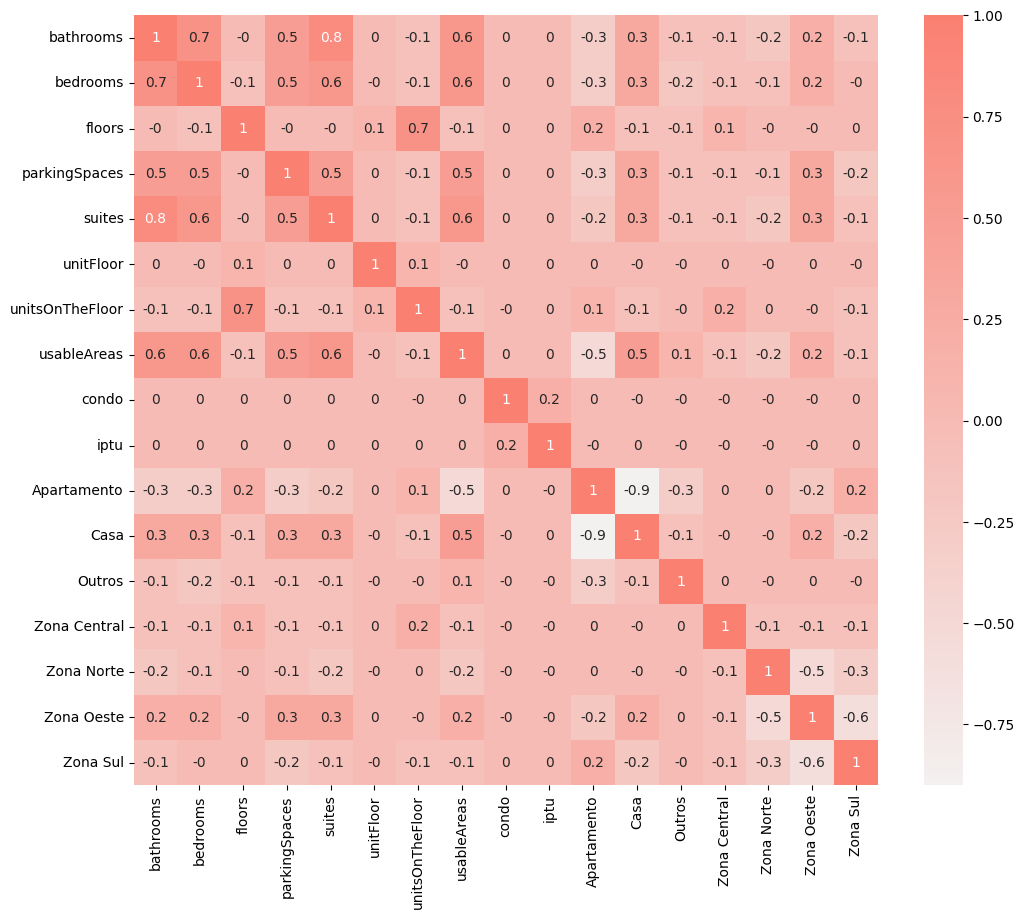

In [49]:
#criar um mapa de calor do dataframe
plt.figure(figsize=(12,10))
paleta = sns.color_palette("light:salmon", as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta) #annot = deixar os valores da correlação

**Criação do modelo**

In [50]:
from pyspark.ml.regression import LinearRegression

In [51]:
treino, teste = dataset_prep.randomSplit([0.7,0.3], seed = 101)

In [52]:
treino.count()

48528

In [53]:
teste.count()

20911

In [54]:
lr = LinearRegression()

In [55]:
modelo_lr = lr.fit(treino)

In [56]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [57]:
previsoes_lr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|443266.04737020144|
|(17,[0,1,2,3,4,5,...|500000.0|1127455.8300462805|
|(17,[0,1,2,3,4,5,...|308615.0|111210.49949889386|
|(17,[0,1,2,3,4,5,...|279000.0|113587.95787719043|
|(17,[0,1,2,3,4,5,...|545000.0|340703.71307873435|
|(17,[0,1,2,3,4,5,...|449000.0|390571.99595798284|
|(17,[0,1,2,3,4,5,...|479000.0| 444003.4297194885|
|(17,[0,1,2,3,4,5,...|420000.0| 720022.1542161054|
|(17,[0,1,2,3,4,5,...|265000.0|519406.05037395435|
|(17,[0,1,2,3,4,5,...|490000.0| 845483.5388437647|
|(17,[0,1,2,3,4,5,...|650000.0| 644931.4982488954|
|(17,[0,1,2,3,4,5,...|379900.0| 448889.3339027724|
|(17,[0,1,2,3,4,5,...|449000.0| 714548.9501108339|
|(17,[0,1,2,3,4,5,...|190000.0| 411726.9411630478|
|(17,[0,1,2,3,4,5,...|896000.0| 597499.4601552959|
|(17,[0,1,2,3,4,5,...|679000.0| 864544.0129262989|
|(17,[0,1,2,3,4,5,...|620000.0|

**Métricas**
O R2 se refere a quanto o modelo está ajustado aos dados.

O RMSE que é o erro médio elevado ao quadrado e depois calculamos a raiz de tudo para verificarmos uma métrica que avalia os erros do modelo e não o modelo em si.

In [58]:
resumo_treino = modelo_lr.summary

In [59]:
resumo_treino.r2

0.6655873678454578

In [60]:
resumo_treino.rootMeanSquaredError

810348.969531623

In [61]:
resumo_teste = modelo_lr.evaluate(teste)

In [62]:
resumo_teste.r2

0.6585207937774393

In [63]:
resumo_teste.rootMeanSquaredError

800525.9696828632

In [64]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)


Linear Regression
Dados de Treino
R²: 0.665587
RMSE: 810348.969532

Dados de Teste
R²: 0.658521
RMSE: 800525.969683


**ÁRVORE DE DECISÃO - DECISION TREE**

In [65]:
from pyspark.ml.regression import DecisionTreeRegressor

In [66]:
dtr = DecisionTreeRegressor(seed = 101, maxDepth = 7)

In [67]:
modelo_dtr = dtr.fit(treino)

In [68]:
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [69]:
previsoes_dtr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|500000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|308615.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|279000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|545000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|479000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|420000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|265000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|490000.0|  820272.937751004|
|(17,[0,1,2,3,4,5,...|650000.0|  736254.943802521|
|(17,[0,1,2,3,4,5,...|379900.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|190000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|896000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|679000.0|1158420.7653661144|
|(17,[0,1,2,3,4,5,...|620000.0|

**Métricas**

Utilizando Avaliador de Regressão

In [70]:
from pyspark.ml.evaluation import RegressionEvaluator

In [71]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))

0.7930752588471226
637436.5434260432


In [72]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [73]:
previsoes_dtr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 350000.0|  820272.937751004|
|(17,[0,1,2,3,4,5,...| 340000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 430000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 600000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 439000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 333000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 948000.0|  736254.943802521|
|(17,[0,1,2,3,4,5,...| 459600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 447600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 360000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 407000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 310000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|1400000.0|1289301.4891122277|
|(17,[0,1,2,3,4,5,...|1180000.0|1289301.4891122277|
|(17,[0,1,2,3,4,5,...|1299500.0|1158420.7653661144|
|(17,[0,1,2,

In [74]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))


Decision Tree Regression
Dados de Treino
R²: 0.793075
RMSE: 637436.543426

Dados de Teste
R²: 0.773813
RMSE: 651518.489921


**RANDOM FOREST PARA REGRESSÃO**

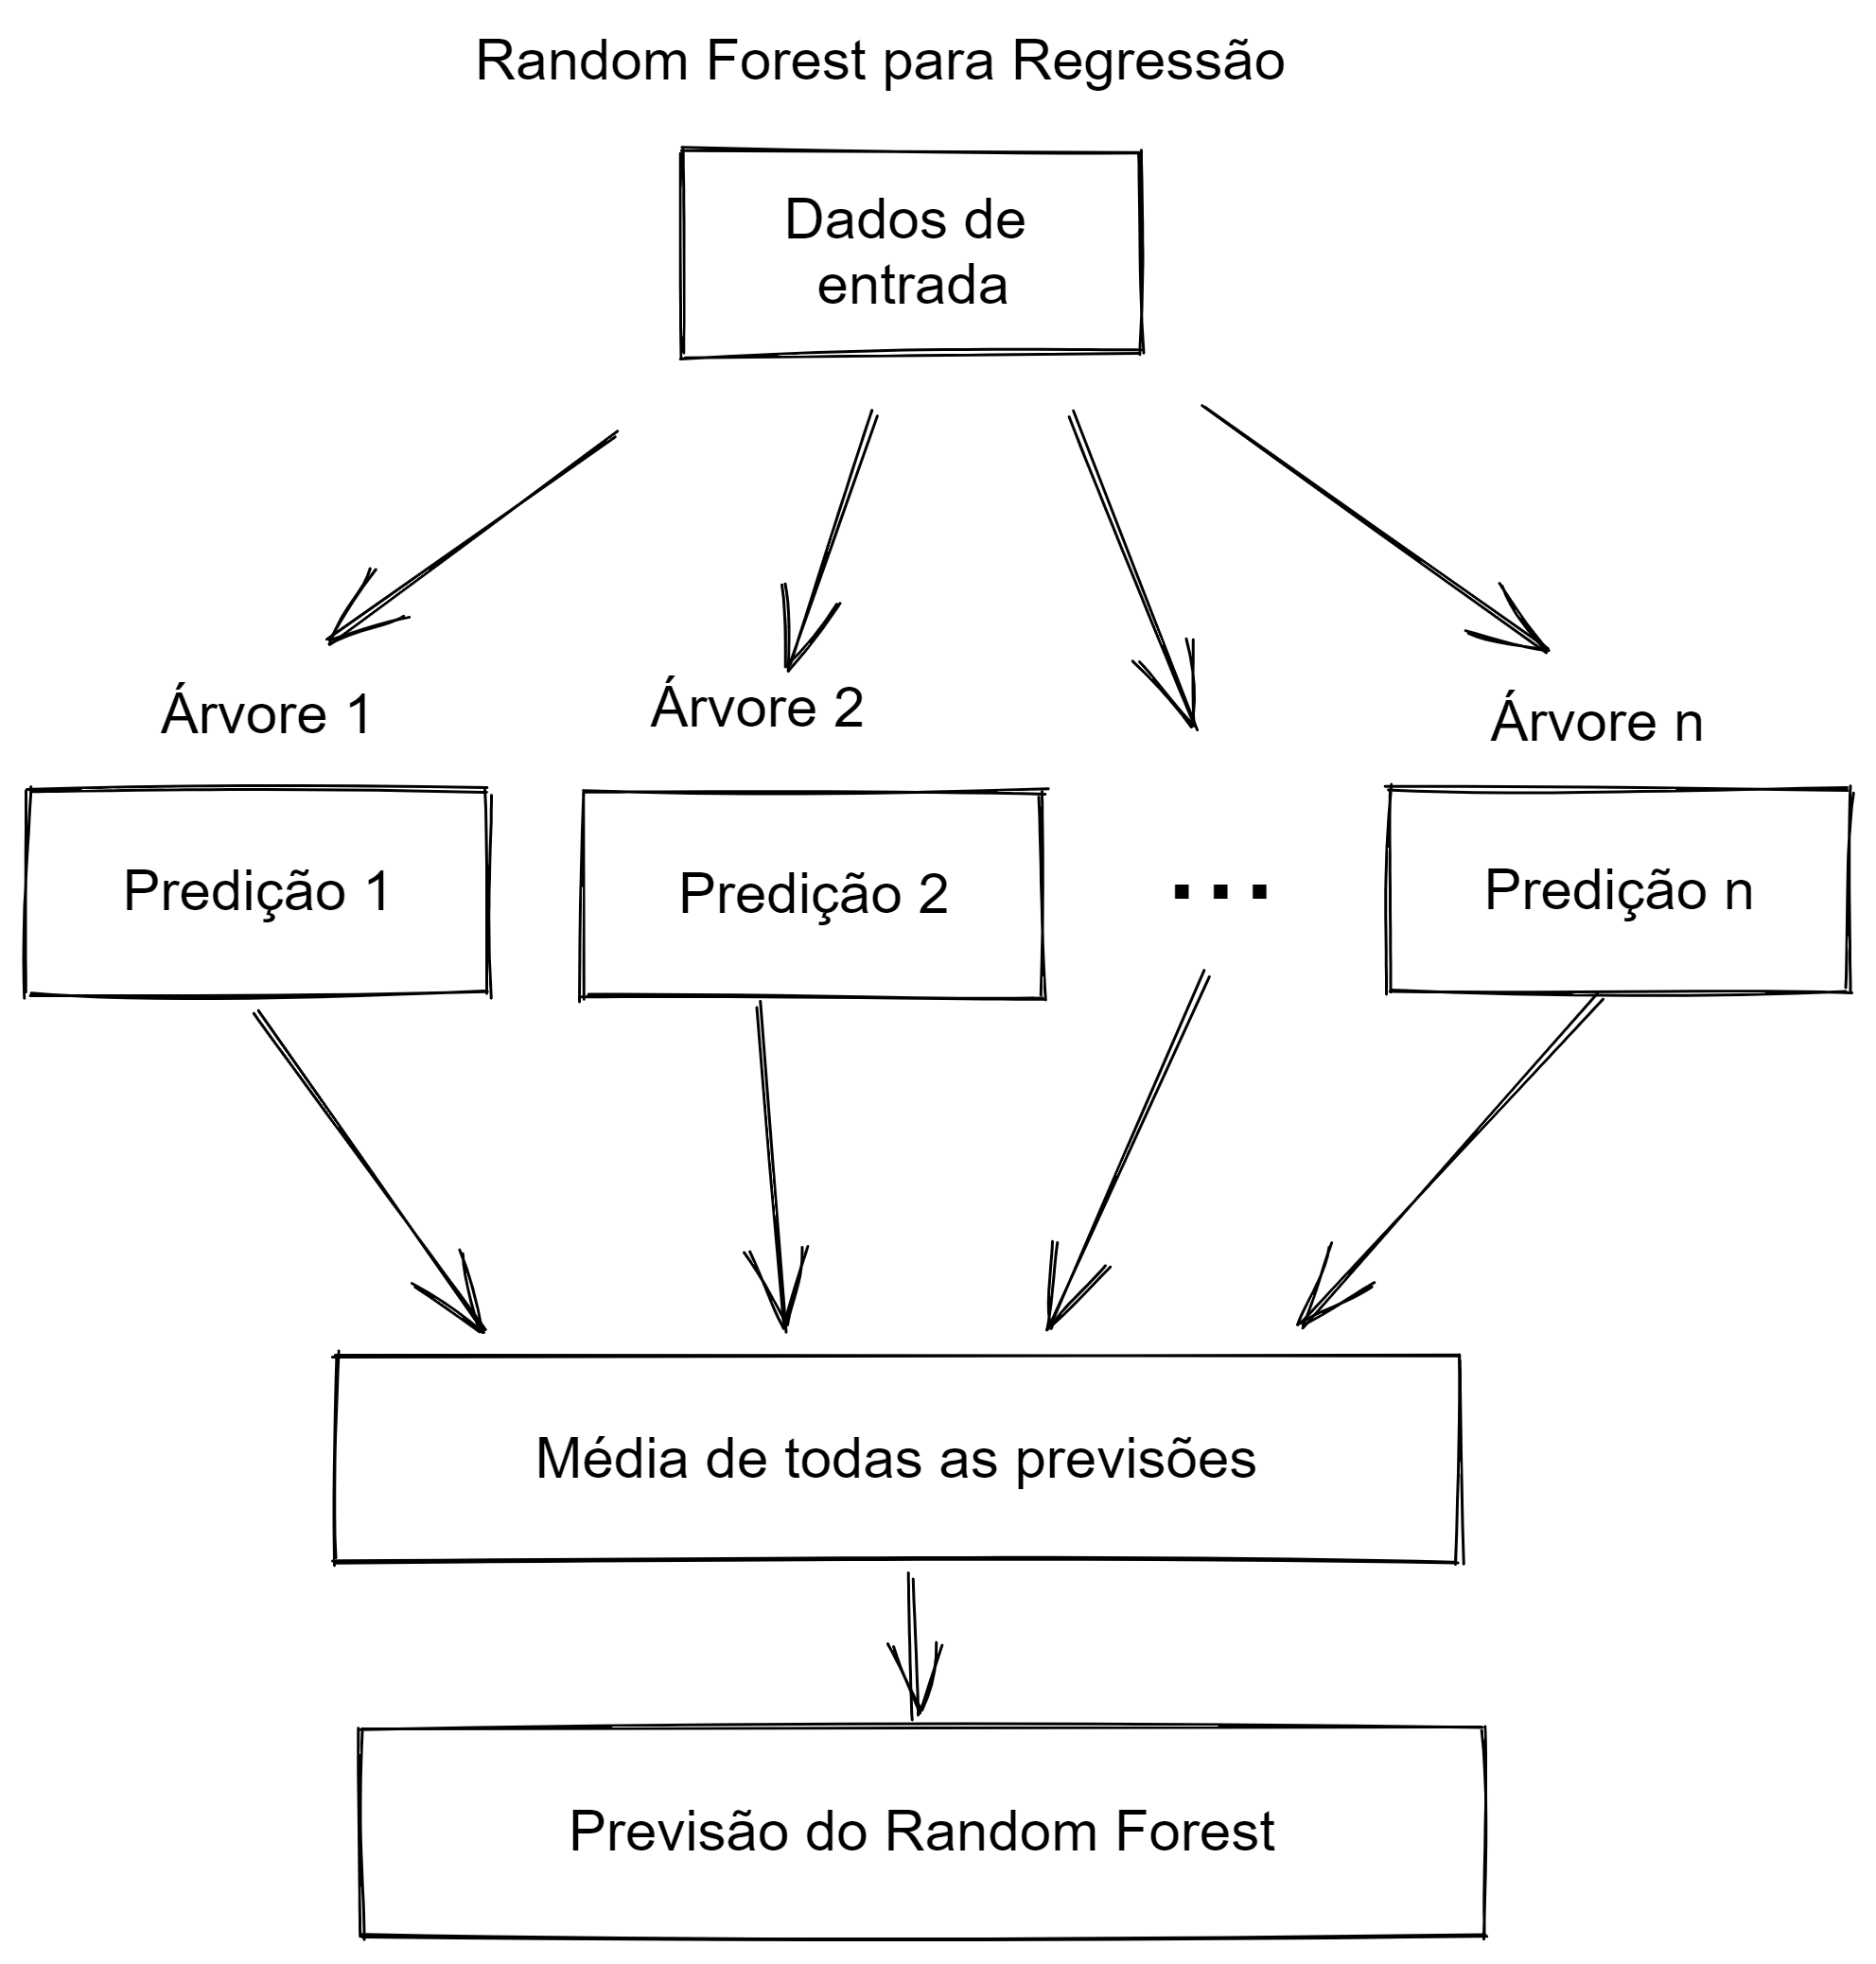

In [75]:
from pyspark.ml.regression import RandomForestRegressor


Criando o modelo, treinando-o e predizendo (treino)

In [76]:
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)
modelo_rfr = rfr.fit(treino)
previsoes_rfr_treino = modelo_rfr.transform(treino)
previsoes_rfr_treino.show()


+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|390218.33742322924|
|(17,[0,1,2,3,4,5,...|500000.0| 510060.6595782173|
|(17,[0,1,2,3,4,5,...|308615.0|360766.74127901345|
|(17,[0,1,2,3,4,5,...|279000.0|360766.74127901345|
|(17,[0,1,2,3,4,5,...|545000.0|  396904.928725379|
|(17,[0,1,2,3,4,5,...|449000.0|  492913.652312712|
|(17,[0,1,2,3,4,5,...|479000.0|433807.13396085694|
|(17,[0,1,2,3,4,5,...|420000.0| 664440.4325776277|
|(17,[0,1,2,3,4,5,...|265000.0|479615.50733929937|
|(17,[0,1,2,3,4,5,...|490000.0| 816123.0337632223|
|(17,[0,1,2,3,4,5,...|650000.0| 640247.1517314625|
|(17,[0,1,2,3,4,5,...|379900.0|403131.21721626434|
|(17,[0,1,2,3,4,5,...|449000.0|403131.21721626434|
|(17,[0,1,2,3,4,5,...|190000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...|896000.0| 547828.3209496561|
|(17,[0,1,2,3,4,5,...|679000.0| 893791.6624292185|
|(17,[0,1,2,3,4,5,...|620000.0|

Métricas

In [77]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))


0.8017561510914318
623922.4426224458


In [78]:
previsoes_rfr_teste = modelo_rfr.transform(teste)
previsoes_rfr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 350678.0454640939|
|(17,[0,1,2,3,4,5,...| 350000.0| 792518.9735011571|
|(17,[0,1,2,3,4,5,...| 340000.0|479615.50733929937|
|(17,[0,1,2,3,4,5,...| 430000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 600000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 439000.0| 550795.8732599718|
|(17,[0,1,2,3,4,5,...| 333000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 948000.0| 640247.1517314625|
|(17,[0,1,2,3,4,5,...| 459600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 447600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 360000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 407000.0|  492913.652312712|
|(17,[0,1,2,3,4,5,...| 310000.0|412580.35636663495|
|(17,[0,1,2,3,4,5,...|1400000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1180000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1299500.0|1111896.8209940076|
|(17,[0,1,2,

In [79]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))


Random Forest Regression
Dados de Treino
R²: 0.801756
RMSE: 623922.442622

Dados de Teste
R²: 0.790530
RMSE: 626981.467738


**OTMIZAÇÃO DO MODELO**

*Cross Validation - Validação Cruzada para Árvore de Decisão* 

In [81]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [82]:
dtr_optimizer = DecisionTreeRegressor()

*ajuste do modelo, passando os parâmetros para que este modelo possa testar saber com qual ele se dará melhor*

In [88]:
grid = ParamGridBuilder() \
    .addGrid(dtr_optimizer.maxDepth, [2, 5, 10]) \
    .addGrid(dtr_optimizer.maxBins, [10, 32, 45]) \
    .build()

 **maxBins** *é a quantidade de vezes que a árvore de decisão tentará montar nós com diferentes condições e o quão refinadas serão essas tentativas para que ela monte esses nós*

In [90]:
evaluator_dtr_optimizer = RegressionEvaluator()

In [92]:
#CrossValidator
dtr_optimize_cv = CrossValidator(
    estimator=dtr_optimizer,
    estimatorParamMaps=grid,
    evaluator=evaluator_dtr_optimizer,
    numFolds=3,
    seed = 101
)

In [93]:
#ajuste dos dados
modelo_dtr_optimize_cv = dtr_optimize_cv.fit(treino)

In [96]:
#previosões
previsoes_dtr_optimize_cv_teste = modelo_dtr_optimize_cv.transform(teste)

In [97]:
print('Decision Tree Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_optimize_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_optimize_cv_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Sem Cross Validation
R²: 0.773813
RMSE: 651518.489921

Com Cross Validation
R²: 0.791608
RMSE: 625365.826510


*Cross Validation - Validação Cruzada para Random Forest*

In [98]:
from pyspark.ml.regression import RandomForestRegressor

In [100]:
rfr_optimize = RandomForestRegressor()

In [101]:
grid = ParamGridBuilder() \
    .addGrid(rfr_optimize.numTrees, [10, 20, 30]) \
    .addGrid(rfr_optimize.maxDepth, [5, 10]) \
    .addGrid(rfr_optimize.maxBins, [10, 32, 45]) \
    .build()

In [103]:
evaluator_rfr_optimize = RegressionEvaluator()

In [104]:
rfr_optimize_cv = CrossValidator(
    estimator=rfr_optimize,
    estimatorParamMaps=grid,
    evaluator=evaluator_rfr_optimize,
    numFolds=3
)

In [105]:
modelo_rfr_optimize_cv = rfr_optimize_cv.fit(treino)

In [106]:
previsoes_rfr_optimize_cv_teste = modelo_rfr_optimize_cv.transform(teste)

In [107]:
print('Random Forest Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_optimize_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_optimize_cv_teste, {evaluator.metricName: "rmse"}))


Random Forest Regression
Sem Cross Validation
R²: 0.790530
RMSE: 626981.467738

Com Cross Validation
R²: 0.830475
RMSE: 564039.629588


**Predição de resultados em função do melhor Modelo**

In [108]:
dataset.show(15)

+---------------+--------------------+------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|        neighborhood|        zone|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|  label|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+--------------------+------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|             Taquara|  Zona Oeste|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

In [110]:
x

['bathrooms',
 'bedrooms',
 'floors',
 'parkingSpaces',
 'suites',
 'unitFloor',
 'unitsOnTheFloor',
 'usableAreas',
 'condo',
 'iptu',
 'Apartamento',
 'Casa',
 'Outros',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

*busca por um imóvel ideal ficticio*

In [111]:
imovel_desejado = [{ 
    'bathrooms': 2,
    'bedrooms': 3,
    'floors': 1,
    'parkingSpaces': 2,
    'suites': 1,
    'unitFloor': 0,
    'unitsOnTheFloor': 0,
    'usableAreas': 200,
    'condo': 300,
    'iptu': 0,
    'Apartamento': 1,
    'Casa': 0,
    'Outros': 0,
    'Zona Central': 1,
    'Zona Norte': 0,
    'Zona Oeste': 0,
    'Zona Sul': 0,
    'label': 0    
}]

In [114]:
my_imovel = spark.createDataFrame(imovel_desejado)
my_imovel.show()

+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+
|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|bathrooms|bedrooms|condo|floors|iptu|label|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|
+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+
|          1|   0|     0|           1|         0|         0|       0|        2|       3|  300|     1|   0|    0|            2|     1|        0|              0|        200|
+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+



In [117]:
#vetorização do dataframe
assembler = VectorAssembler(inputCols = x, outputCol= 'features')

In [118]:
my_home_vectorize = assembler.transform(my_imovel).select('features', 'label')

In [119]:
my_home_vectorize.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(17,[0,1,2,3,4,7,...|    0|
+--------------------+-----+



In [120]:
modelo_rfr_optimize_cv.transform(my_home_vectorize).show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|(17,[0,1,2,3,4,7,...|    0|1235822.4685746075|
+--------------------+-----+------------------+

